# Import Necessary libraries

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.utils import resample, shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from textwrap import wrap

%matplotlib inline


# Import Raw Data
View a few records. Notice that the label is the 'Class' column
- '4' is malignant
- '2' is benign


In [2]:
df = pd.read_csv('breast-cancer-wisconsin.txt')
df.head()


,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4


We have 15,855 records

In [3]:
df.shape

(15855, 12)

What Classes do we have?

In [4]:
df['Class'].unique()

array(['4', '2', 'No idea', '40', nan, '#', '?', '20'], dtype=object)

### Eliminate non-relevant classes
We are only interested in benign (Class = '2') and malignant (Class = '4') cases


In [5]:
df = df.loc[ df['Class'].isin(['4', '2']) ]

Now we have 15620 records

In [6]:
assert(df.shape == (15620,12))

In [7]:
df.head()


,Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0,1241035,7,8,3,7,4,5,7,8,2,4
1,1,1107684,6,10,5,5,4,10,6,10,1,4
2,2,691628,8,6,4,10,10,1,3,5,1,4
3,3,1226612,7,5,6,3,3,8,7,4,1,4
4,4,1142706,5,10,10,10,6,10,6,5,2,4


## Remove missing data
Remove rows with missing data

In [8]:
# Remove Missing Data
df = df[~(df['Bare Nuclei'] == '?')]
assert(df.shape == (15604,12))


### Convert to int datatype
- Convert all input to int
- Convert malignant (4) to label 1, benign (2) as 0

In [9]:
df = df.astype(int)
df['Class'] = df['Class'].apply(lambda x : 1 if x == 4 else 0) #malignant now becomes 1

In [10]:
df['Class'].value_counts()
#must be 15162 malignant (1) and 442 benign (0)

1    15162
0      442
Name: Class, dtype: int64

In [11]:
MALIGNANT_LABEL = 1
BENIGN_LABEL = 0

### Shuffle the dataframe

In [12]:
#Shuffle data (randomize)
df = df.sample(frac=1, random_state=7).reset_index(drop=True)


# Class Imbalance
Separate the benigns and malignants. Create co-variance heatmap


In [13]:
df['Class'].value_counts()

1    15162
0      442
Name: Class, dtype: int64

In [14]:
df_majority = df.loc[df['Class'] == MALIGNANT_LABEL] #majority class
df_minority = df.loc[ df['Class'] == BENIGN_LABEL ] #minority class

n_majority = df_majority.shape[0] #15162
n_minority = df_minority.shape[0] #442
assert(n_majority == 15162)
assert(n_minority == 442)


In [15]:
#exclude Index, ID, Class columns
df.loc[:, ~df.columns.isin(['Index', 'ID', 'Class'])].corr().style.background_gradient(cmap='coolwarm')


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
Clump Thickness,1,0.0532796,0.111818,-0.363252,0.119677,0.164924,0.0763733,-0.092438,-0.0984202
Uniformity of Cell Size,0.0532796,1,0.660188,-0.0174228,0.0727896,0.308825,0.304463,0.671795,-0.255565
Uniformity of Cell Shape,0.111818,0.660188,1,-0.1916,0.0434639,0.313378,0.131744,0.375438,-0.112872
Marginal Adhesion,-0.363252,-0.0174228,-0.1916,1,0.528456,-0.113965,0.0770483,-0.126606,-0.0554153
Single Epithelial Cell Size,0.119677,0.0727896,0.0434639,0.528456,1,-0.217674,0.198993,-0.00956579,-0.128378
Bare Nuclei,0.164924,0.308825,0.313378,-0.113965,-0.217674,1,0.246314,-0.0543458,-0.17669
Bland Chromatin,0.0763733,0.304463,0.131744,0.0770483,0.198993,0.246314,1,0.0772254,-0.170568
Normal Nucleoli,-0.092438,0.671795,0.375438,-0.126606,-0.00956579,-0.0543458,0.0772254,1,-0.196118
Mitoses,-0.0984202,-0.255565,-0.112872,-0.0554153,-0.128378,-0.17669,-0.170568,-0.196118,1


### Split into train, test

In [16]:
getX = lambda df : df.loc[:, ~df.columns.isin(['Index', 'ID', 'Class'])].values.astype(int)
getY = lambda df : df.loc[:, 'Class'].values.astype(int)

from sklearn.model_selection import train_test_split
def create_train_test(minority, majority):
    X_minority = getX(minority)
    y_minority = getY(minority)
    X_majority = getX(majority)
    y_majority = getY(majority)
    
    X_nb, X_tb, y_nb, y_tb = train_test_split(X_minority, y_minority, test_size=0.2, random_state=7)
    X_nm, X_tm, y_nm, y_tm = train_test_split(X_majority, y_majority, test_size=0.2, random_state=7)
    X_train = np.append(X_nb, X_nm, axis=0)
    y_train = np.append(y_nb, y_nm)
    X_test = np.append(X_tb, X_tm, axis=0)
    y_test = np.append(y_tb, y_tm)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = create_train_test(df_minority, df_majority)

In [21]:
assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])

# must be 12482, 3122
assert(X_train.shape[0] == 12482)
assert(X_test.shape[0] == 3122)

#Train sizes must be 80% of total
assert(np.floor(n_minority*0.8) == (y_train == 0).sum()) # 353
assert(np.floor(n_majority*0.8) == (y_train == 1).sum()) # 12129


### Upsample the minority class in training set

In [22]:
#Upsample minority class (majority)
#upsample to match minority class
def get_balanced_Xy(X, y):
    #majority
    X_majority = X[y == MALIGNANT_LABEL]
    y_majority = y[y == MALIGNANT_LABEL]
        
    #minority
    X_minority = X[y == BENIGN_LABEL]
    y_minority = y[y == BENIGN_LABEL]
    
    n_count = X_majority.shape[0]
    X_min_upsampled, y_min_upsampled = resample(X_minority, y_minority, replace=True, 
                                                n_samples=n_count, random_state=7)
    X_train = np.append(X_majority, X_min_upsampled, axis=0)
    y_train = np.append(y_majority, y_min_upsampled)
    X_train, y_train = shuffle(X_train, y_train, random_state=7)
    return X_train, np.squeeze(y_train)
X_train, y_train = get_balanced_Xy(X_train, y_train)

In [24]:
assert(X_train.shape[0] == y_train.shape[0])
assert(X_train.shape[0] == 2*(np.floor(n_majority*0.8))) # 24258 = 2*12129

## Logistic Regression Model

In [25]:
#Learn from training data
scaler = StandardScaler().fit(X_train)
X_scaled = scaler.transform(X_train)
model = LogisticRegression().fit(X=X_scaled, y=y_train)


/Users/vmullachery/anaconda/envs/dl3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


### Prediction

In [26]:
# Predict
X_scaled = scaler.transform(X_test)
y_pred = model.predict(X_scaled)
accuracy_score(y_test, y_pred)

/Users/vmullachery/anaconda/envs/dl3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.99679692504804618

In [28]:
(y_pred==MALIGNANT_LABEL).sum() #Predicted Malignant


3025

 None]

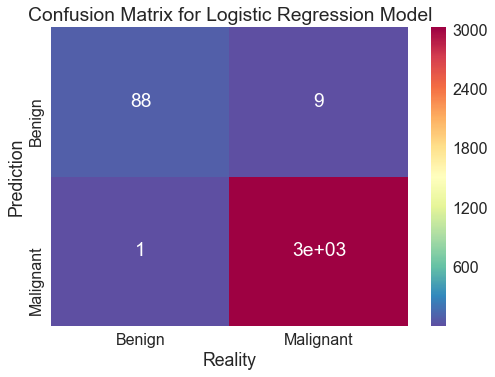

In [30]:
cm = confusion_matrix(y_test, y_pred).T
cmdf = pd.DataFrame(cm, index=['Benign', 'Malignant'], columns=['Benign', 'Malignant'])
sns.set(font_scale=1.6)
ax = sns.heatmap(cmdf, annot=True, cmap='Spectral_r')
ax.set(xlabel='Reality', ylabel='Prediction', label='large bold', 
       title='Confusion Matrix for Logistic Regression Model')

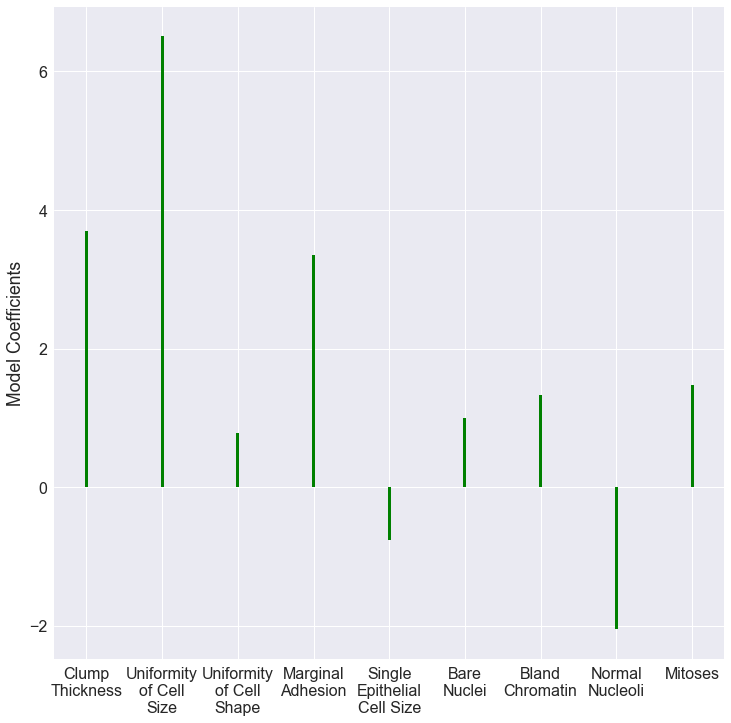

In [31]:
column_names = df.columns[~df.columns.isin(['Index', 'ID', 'Class'])]
xpos = [20*i for i, _ in enumerate(column_names)]
model_coeffs = np.squeeze(model.coef_)
plt.figure(figsize=(12,12))
plt.bar(xpos, model_coeffs,color='green')
display_names = ['\n'.join(wrap(c,10)) for c in column_names]
plt.xticks(xpos, display_names )
plt.ylabel('Model Coefficients')

In [34]:
X_scaled = scaler.transform(X_test)
y_pred_proba = model.predict_proba(X_scaled)
y_pred = model.predict(X_scaled)
p_mal = [a[1] for a in y_pred_proba] #prob of malignancy
#y_pred[-5:], p_mal[-5:]
roc_auc_score(y_test, p_mal)

/Users/vmullachery/anaconda/envs/dl3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


0.9902236447763737

(3122, 3122, 3, 3, 3)

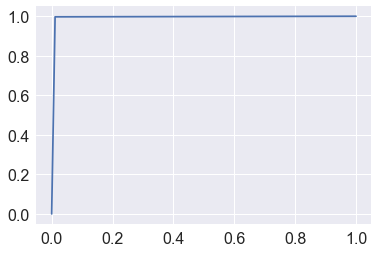

In [46]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)

len(y_pred), len(y_test), len(fpr), len(tpr), len(thresholds)

In [47]:
tpr, fpr, thresholds

(array([ 0.        ,  0.99703264,  1.        ]),
 array([ 0.        ,  0.01123596,  1.        ]),
 array([2, 1, 0]))